# GP optimizer for one single hexapole

**Note**: In order to use it on a specific machine, you should build machine interface (setX and get_state functions).


In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import pickle
import numpy as np
from modules.bayes_optimization import BayesOpt, negUCB, negExpImprove
from modules.OnlineGP import OGP
import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import sys
import os
sys.path.insert(1, '/home/cz489/STEMalign_BO/GPTrelated')
saveResultsQ = False
import scipy

failed to import parallelstuff


### Creat the machine interface

In [91]:
ndim = 2 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation

dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
start_point = [[0,-9.9]]
#min-max range

#creat machine interface
mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
# mi_module = importlib.import_module('multinormal')
mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) 
# assuming an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background 
# noise with std dev = 0.1

In [92]:
mi.x

array([[ 0. , -9.9]])

In [93]:
#check the reading objective is working
mi.getState()

/nfs/user/cz489/venv/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/nfs/user/cz489/venv/lib64/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(array([[ 0. , -9.9]]), array([[-5842525.48315751]]))

In [21]:
#check noise std
y = [mi.getState()[1][0] for x in range(5)]
np.std(y)

0.0

### Create the gp

In [97]:
gp_ls = np.array(np.ones(ndim))
gp_amp = 3e5 # default = 1
gp_noise = 10  # default = 0.001

gp_precisionmat =  np.array(np.diag(1/(gp_ls**2)))
hyps = [gp_precisionmat, np.log(gp_amp), np.log(gp_noise**2)] #format the hyperparams for the OGP

gp = OGP(ndim, hyps,prmean=0)

### Create the BO

In [98]:
#create the bayesian optimizer that will use the gp as the model to optimize the machine 
opt = BayesOpt(gp, mi, acq_func="UCB", start_dev_vals = mi.x, dev_ids = dev_ids)
opt.ucb_params = np.array([2, None])

target_func =  <machine_interfaces.machine_interface_GPT.machine_interface object at 0x7f3e10a702e8>
********* BO - self.mi = self.target_func wORKED!
Supposed to be grabbing initial machine state...
x_init [[ 0.  -9.9]]
y_init [[-5842525.48315751]]
Using prior mean function of  0
Using prior mean parameters of  None


**Running BO**

*run the gp search for some number of steps*

In [99]:
Obj_state_s=[]
Obj_state_s.append(mi.getState()[1][0])

iteration = 0
current position: [[ 0.  -9.9]] current best seen objective value: [-5842525.48315751]


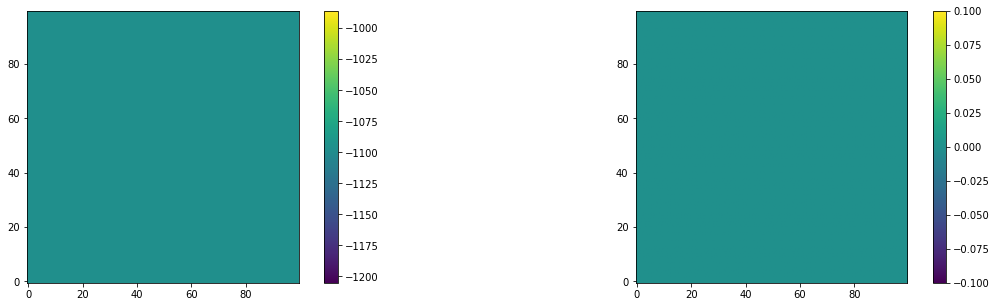

[ 0.  -9.9] [[-5842525.48315751]]
[ 0.  -9.9]
single-processing, minimize, x_start = [-0.37438343936958807, -10.211122141692586]
Minimizing finished, min point = [ -0.37438344 -10.        ]
New State: [[ -0.37438344 -10.        ]], [[-5750271.4362236]]
iteration = 1
current position: [[ -0.37438344 -10.        ]] current best seen objective value: [[-5750271.4362236]]


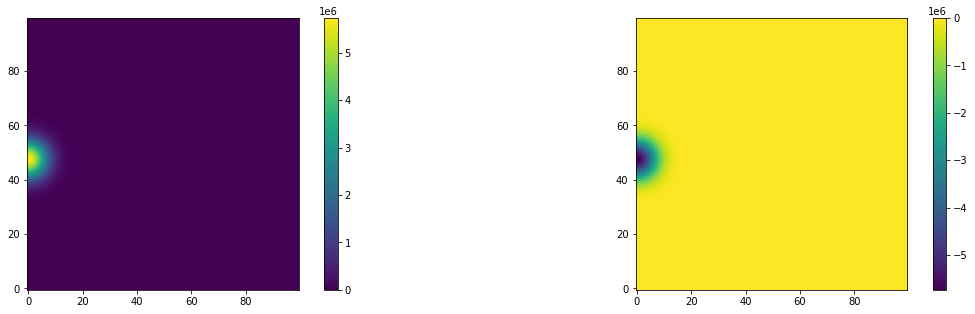

[ -0.37438344 -10.        ] [[-5750271.4362236]]
[ -0.37438344 -10.        ]
single-processing, minimize, x_start = [-0.5718584340540352, -9.907945566313597]
Minimizing finished, min point = [-6. 10.]
New State: [[-6. 10.]], [[-921690.44120017]]
iteration = 2
current position: [[-6. 10.]] current best seen objective value: [[-921690.44120017]]


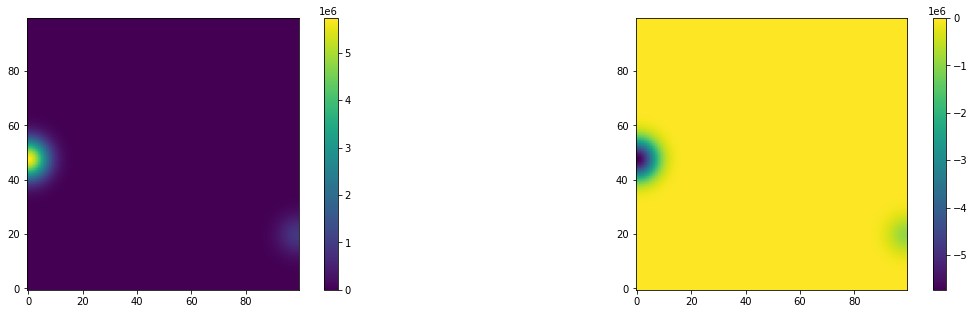

[-6. 10.] [[-921690.44120017]]
[-6. 10.]
single-processing, minimize, x_start = [-6.107498902429363, 9.762337308666138]
Minimizing finished, min point = [ -6. -10.]
New State: [[ -6. -10.]], [[-922537.85602027]]
iteration = 3
current position: [[ -6. -10.]] current best seen objective value: [[-921690.44120017]]


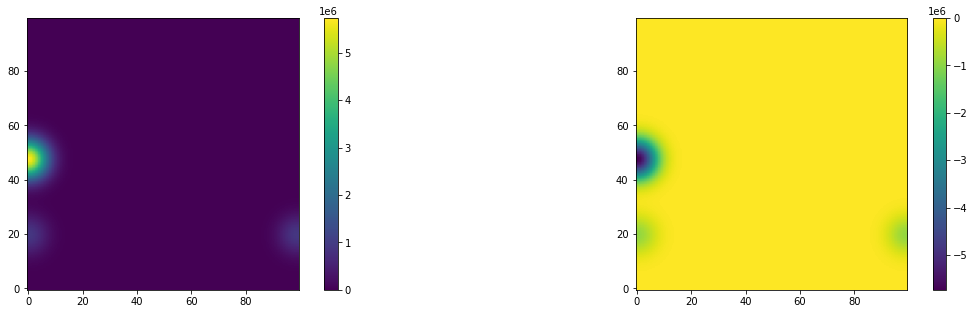

[-6. 10.] [[-921690.44120017]]
[-6. 10.]
single-processing, minimize, x_start = [-6.285271780333297, 9.887477162021362]
Minimizing finished, min point = [-6.          3.27661263]
New State: [[-6.          3.27661263]], [[-574306.84331233]]
iteration = 4
current position: [[-6.          3.27661263]] current best seen objective value: [[-574306.84331233]]


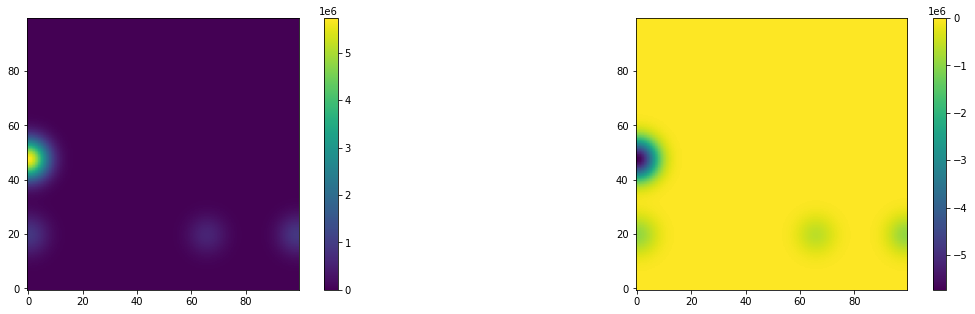

[-6.          3.27661263] [[-574306.84331233]]
[-6.          3.27661263]
single-processing, minimize, x_start = [-6.091526638299323, 3.3481660203592107]
Minimizing finished, min point = [0.74543556 8.60742907]
New State: [[0.74543556 8.60742907]], [[-5650663.33974791]]
iteration = 5
current position: [[0.74543556 8.60742907]] current best seen objective value: [[-574306.84331233]]


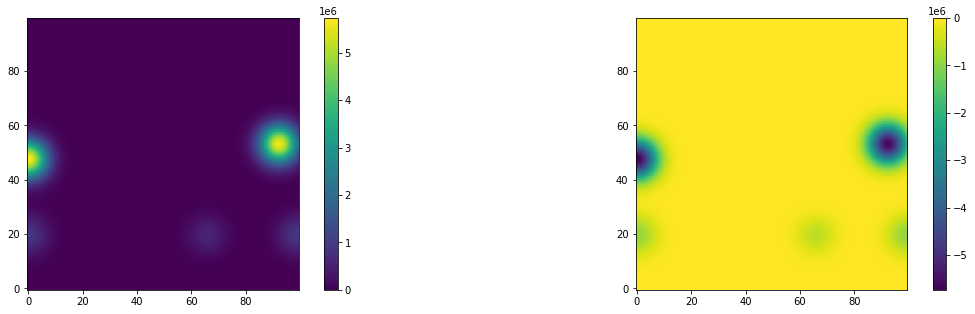

[-6.          3.27661263] [[-574306.84331233]]
[-6.          3.27661263]
single-processing, minimize, x_start = [-5.934415135879039, 2.9775529379888193]
Minimizing finished, min point = [  6. -10.]
New State: [[  6. -10.]], [[-951008.28159938]]
iteration = 6
current position: [[  6. -10.]] current best seen objective value: [[-574306.84331233]]


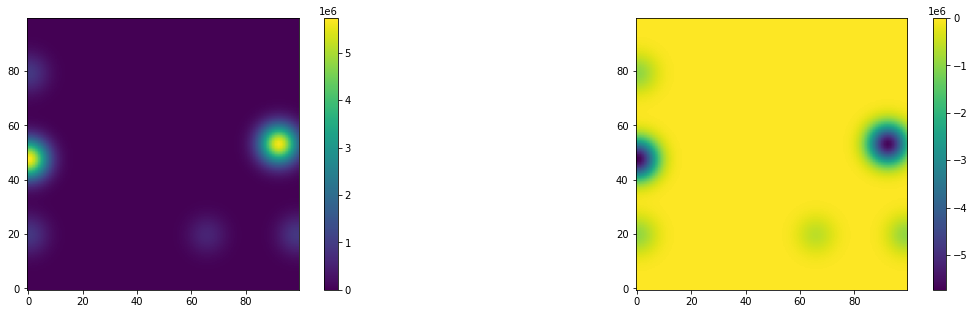

[-6.          3.27661263] [[-574306.84331233]]
[-6.          3.27661263]
single-processing, minimize, x_start = [-6.222466411656822, 3.674447232196192]
Minimizing finished, min point = [-6.          6.56111746]
New State: [[-6.          6.56111746]], [[-95068.24623762]]
iteration = 7
current position: [[-6.          6.56111746]] current best seen objective value: [[-95068.24623762]]


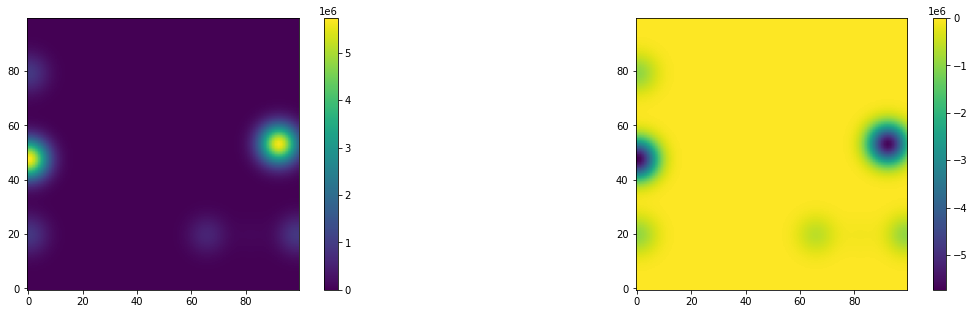

[-6.          6.56111746] [[-95068.24623762]]
[-6.          6.56111746]
single-processing, minimize, x_start = [-5.614303977872161, 6.120519771178169]
Minimizing finished, min point = [2.0172773  1.32807992]
New State: [[2.0172773  1.32807992]], [[-716766.83687803]]
iteration = 8
current position: [[2.0172773  1.32807992]] current best seen objective value: [[-95068.24623762]]


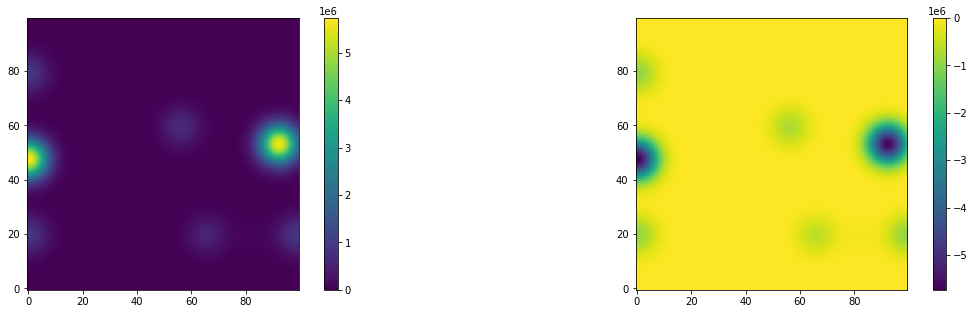

[-6.          6.56111746] [[-95068.24623762]]
[-6.          6.56111746]
single-processing, minimize, x_start = [-5.706124571434218, 6.926472394462792]
Minimizing finished, min point = [ 6. 10.]
New State: [[ 6. 10.]], [[-909560.60057203]]
iteration = 9
current position: [[ 6. 10.]] current best seen objective value: [[-95068.24623762]]


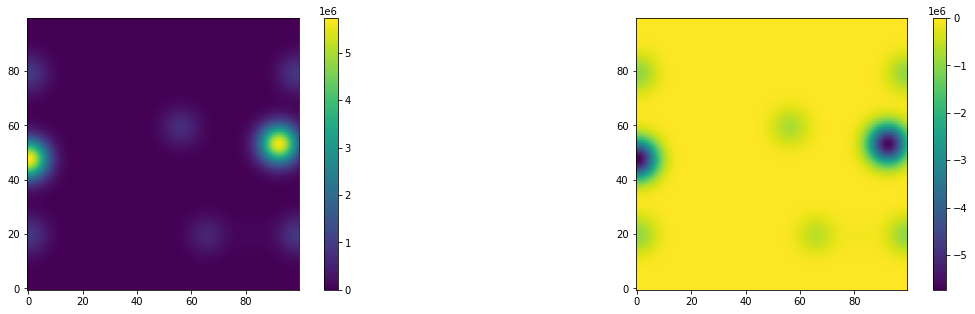

[-6.          6.56111746] [[-95068.24623762]]
[-6.          6.56111746]
single-processing, minimize, x_start = [-6.008248971347235, 6.103489095684552]
Minimizing finished, min point = [-1.60092848  4.14187476]
New State: [[-1.60092848  4.14187476]], [[-506327.92468829]]
iteration = 10
current position: [[-1.60092848  4.14187476]] current best seen objective value: [[-95068.24623762]]


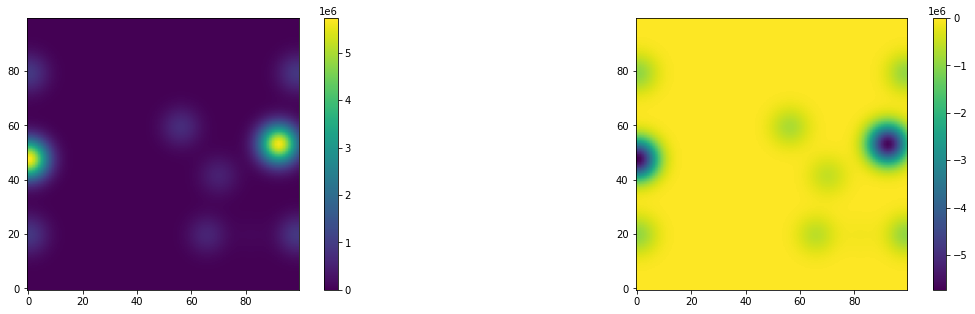

[-6.          6.56111746] [[-95068.24623762]]
[-6.          6.56111746]
single-processing, minimize, x_start = [-5.590340629802507, 6.3370020321771525]
Minimizing finished, min point = [-3.21099331  7.43397787]
New State: [[-3.21099331  7.43397787]], [[-969778.49879708]]
iteration = 11
current position: [[-3.21099331  7.43397787]] current best seen objective value: [[-95068.24623762]]


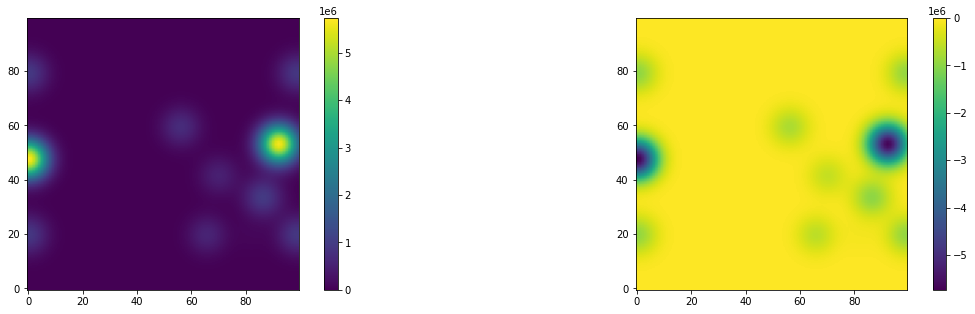

[-6.          6.56111746] [[-95068.24623762]]
[-6.          6.56111746]
single-processing, minimize, x_start = [-6.273756376696549, 6.12282945182208]
Minimizing finished, min point = [-6.          5.86309719]
New State: [[-6.          5.86309719]], [[-75735.14205484]]
iteration = 12
current position: [[-6.          5.86309719]] current best seen objective value: [[-75735.14205484]]


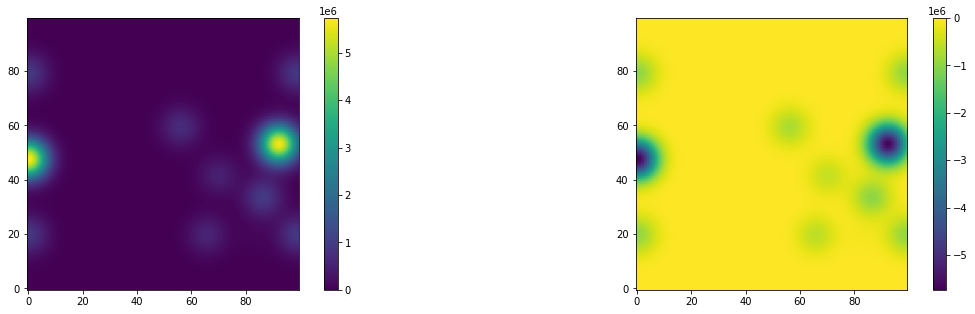

[-6.          5.86309719] [[-75735.14205484]]
[-6.          5.86309719]
single-processing, minimize, x_start = [-6.244084518076126, 5.411216780782364]
Minimizing finished, min point = [-6.          5.77600724]
New State: [[-6.          5.77600724]], [[-78459.4203653]]
iteration = 13
current position: [[-6.          5.77600724]] current best seen objective value: [[-75735.14205484]]


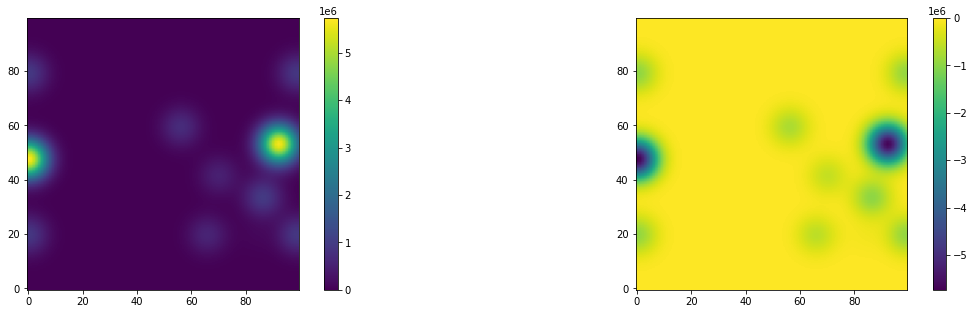

[-6.          5.86309719] [[-75735.14205484]]
[-6.          5.86309719]
single-processing, minimize, x_start = [-6.075333511271783, 5.7999893812451395]
Minimizing finished, min point = [-6.          5.92533534]
New State: [[-6.          5.92533534]], [[-76099.07187259]]
iteration = 14
current position: [[-6.          5.92533534]] current best seen objective value: [[-75735.14205484]]


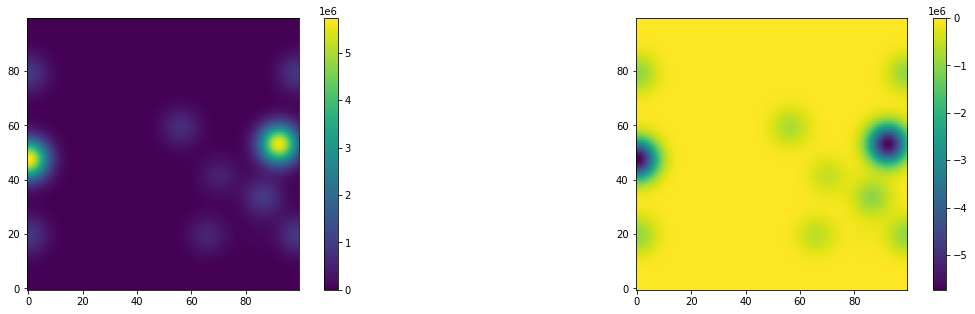

[-6.          5.86309719] [[-75735.14205484]]
[-6.          5.86309719]
single-processing, minimize, x_start = [-6.178710327525963, 5.610207268002416]
Minimizing finished, min point = [-6.          5.92565488]
New State: [[-6.          5.92565488]], [[-76096.07098401]]
iteration = 15
current position: [[-6.          5.92565488]] current best seen objective value: [[-75735.14205484]]


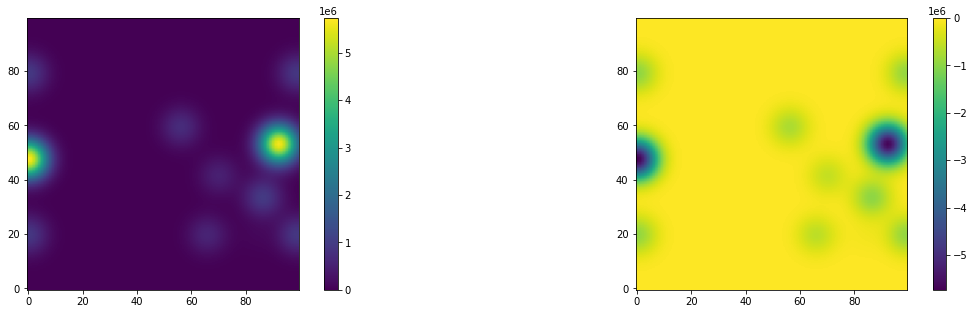

[-6.          5.86309719] [[-75735.14205484]]
[-6.          5.86309719]
single-processing, minimize, x_start = [-5.90663907039226, 6.321629646409309]
Minimizing finished, min point = [-6.          5.92542129]
New State: [[-6.          5.92542129]], [[-76096.41087097]]
iteration = 16
current position: [[-6.          5.92542129]] current best seen objective value: [[-75735.14205484]]


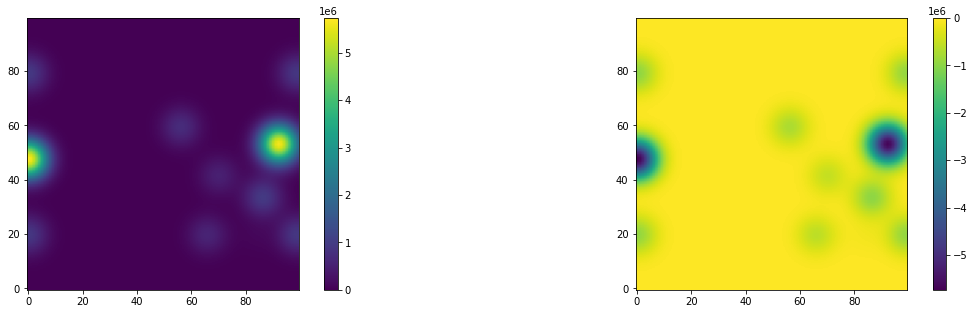

[-6.          5.86309719] [[-75735.14205484]]
[-6.          5.86309719]
single-processing, minimize, x_start = [-6.364774253797569, 5.866106922882374]
Minimizing finished, min point = [-6.          5.92566228]
New State: [[-6.          5.92566228]], [[-76096.17395199]]
iteration = 17
current position: [[-6.          5.92566228]] current best seen objective value: [[-75735.14205484]]


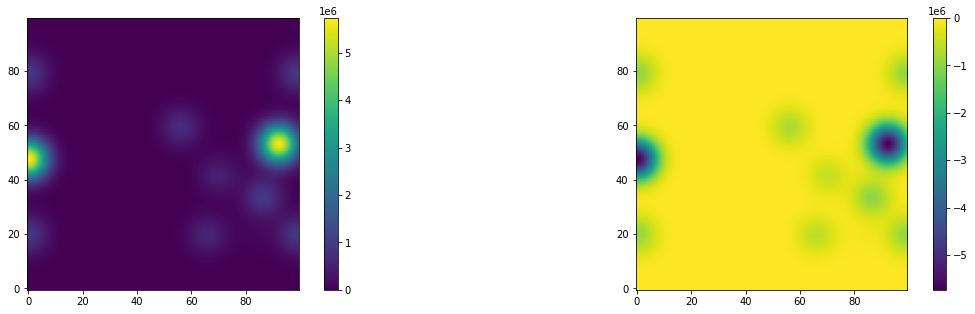

[-6.          5.86309719] [[-75735.14205484]]
[-6.          5.86309719]
single-processing, minimize, x_start = [-5.855538488603584, 6.2004340593512675]
Minimizing finished, min point = [-6.         5.9255182]
New State: [[-6.         5.9255182]], [[-76096.99152196]]
iteration = 18
current position: [[-6.         5.9255182]] current best seen objective value: [[-75735.14205484]]


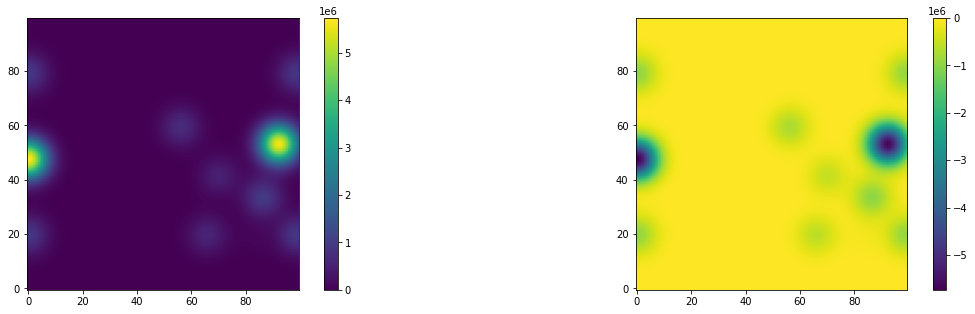

[-6.          5.86309719] [[-75735.14205484]]
[-6.          5.86309719]
single-processing, minimize, x_start = [-5.587955483207688, 6.32417344780676]
Minimizing finished, min point = [-6.          5.92580576]
New State: [[-6.          5.92580576]], [[-76097.12086675]]
iteration = 19
current position: [[-6.          5.92580576]] current best seen objective value: [[-75735.14205484]]


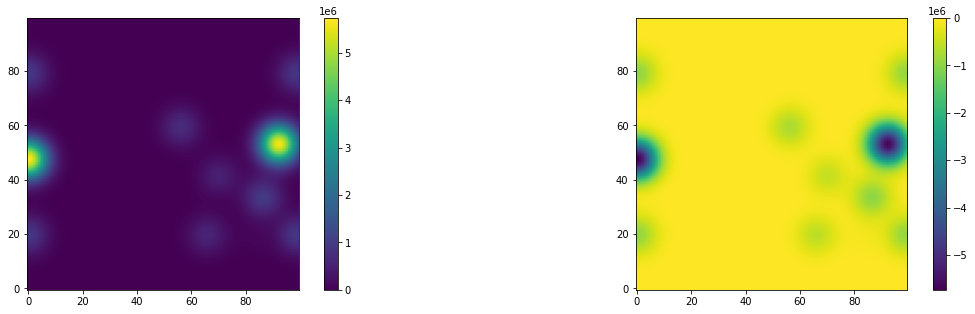

[-6.          5.86309719] [[-75735.14205484]]
[-6.          5.86309719]
single-processing, minimize, x_start = [-6.378645416238542, 5.504227001768879]
Minimizing finished, min point = [-6.          5.92555444]
New State: [[-6.          5.92555444]], [[-76096.36838709]]
iteration = 20
current position: [[-6.          5.92555444]] current best seen objective value: [[-75735.14205484]]


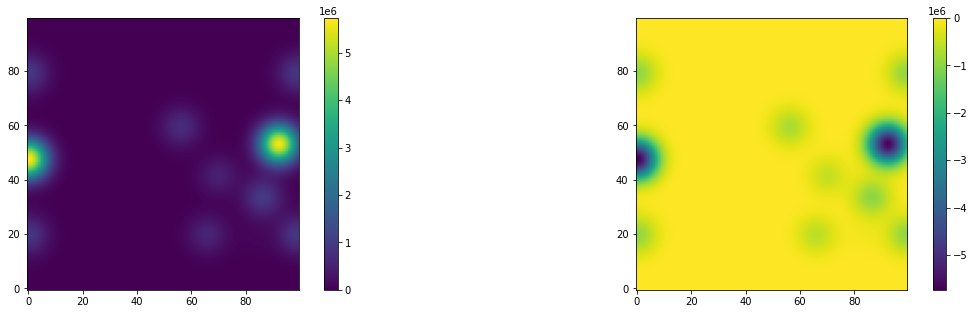

[-6.          5.86309719] [[-75735.14205484]]
[-6.          5.86309719]
single-processing, minimize, x_start = [-6.4041342531129954, 5.458264219500566]
Minimizing finished, min point = [-6.          5.92552721]
New State: [[-6.          5.92552721]], [[-76096.48807096]]
iteration = 21
current position: [[-6.          5.92552721]] current best seen objective value: [[-75735.14205484]]


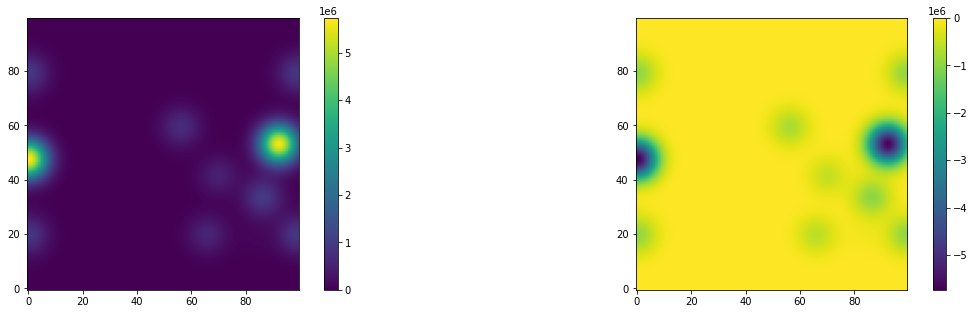

[-6.          5.86309719] [[-75735.14205484]]
[-6.          5.86309719]
single-processing, minimize, x_start = [-5.506289973216767, 6.084361755665406]
Minimizing finished, min point = [-6.          5.92560725]
New State: [[-6.          5.92560725]], [[-76095.73008625]]
iteration = 22
current position: [[-6.          5.92560725]] current best seen objective value: [[-75735.14205484]]


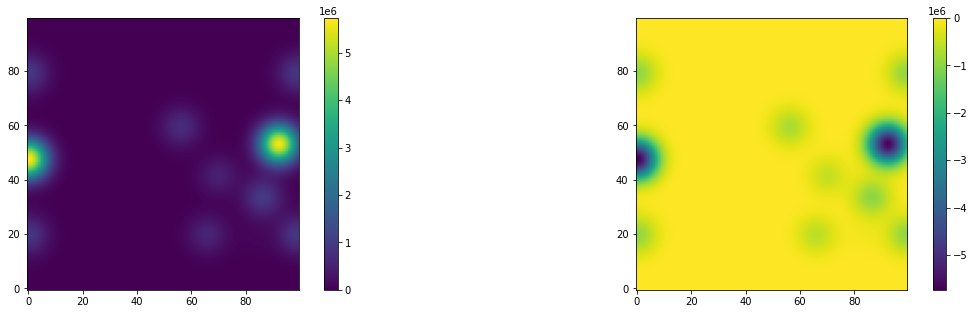

[-6.          5.86309719] [[-75735.14205484]]
[-6.          5.86309719]
single-processing, minimize, x_start = [-5.667084078134055, 6.306784488251057]
Minimizing finished, min point = [-6.          5.92578131]
New State: [[-6.          5.92578131]], [[-76096.99512866]]
iteration = 23
current position: [[-6.          5.92578131]] current best seen objective value: [[-75735.14205484]]


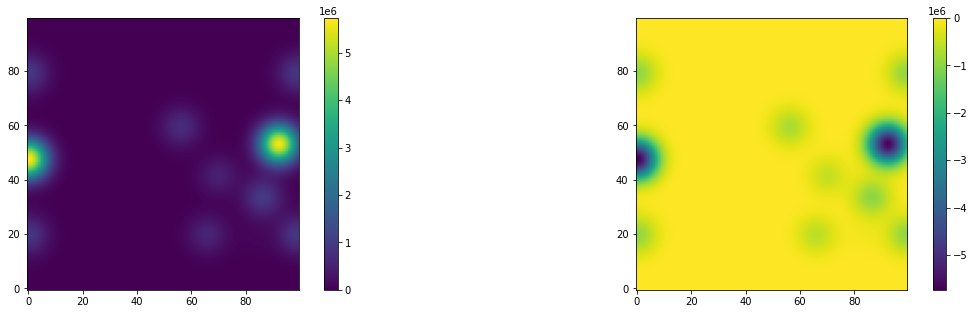

[-6.          5.86309719] [[-75735.14205484]]
[-6.          5.86309719]
single-processing, minimize, x_start = [-5.712990647364464, 5.852715641969587]
Minimizing finished, min point = [-5.71321299  5.85592851]
New State: [[-5.71321299  5.85592851]], [[-77079.3018338]]
iteration = 24
current position: [[-5.71321299  5.85592851]] current best seen objective value: [[-75735.14205484]]


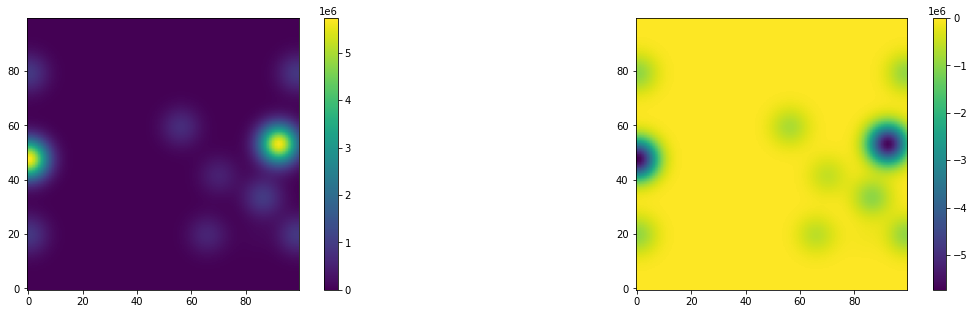

[-6.          5.86309719] [[-75735.14205484]]
[-6.          5.86309719]
single-processing, minimize, x_start = [-5.609833195543157, 6.354030637795519]
Minimizing finished, min point = [-5.58869414  5.81016021]
New State: [[-5.58869414  5.81016021]], [[-78698.17543323]]
iteration = 25
current position: [[-5.58869414  5.81016021]] current best seen objective value: [[-75735.14205484]]


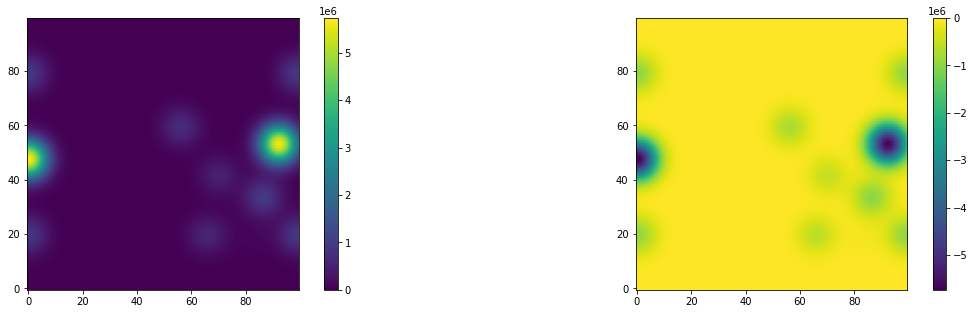

[-6.          5.86309719] [[-75735.14205484]]
[-6.          5.86309719]
single-processing, minimize, x_start = [-5.898299864333064, 5.499858802610108]
Minimizing finished, min point = [-6.          5.92684353]
New State: [[-6.          5.92684353]], [[-76106.13331568]]
iteration = 26
current position: [[-6.          5.92684353]] current best seen objective value: [[-75735.14205484]]


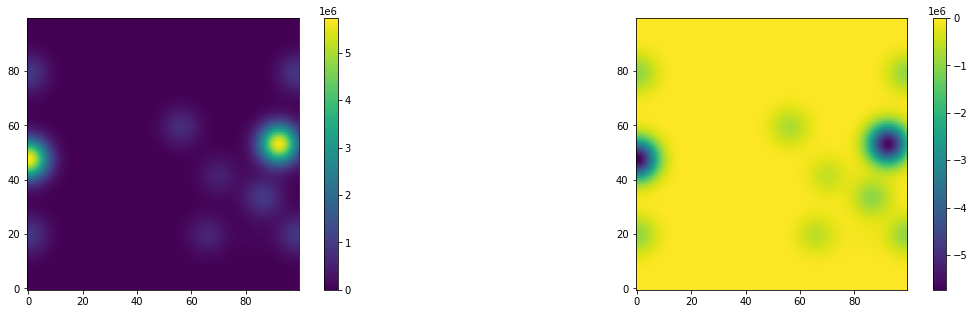

[-6.          5.86309719] [[-75735.14205484]]
[-6.          5.86309719]
single-processing, minimize, x_start = [-5.5558862695313, 6.226254257585867]
Minimizing finished, min point = [-6.          5.92677134]
New State: [[-6.          5.92677134]], [[-76107.76099127]]
iteration = 27
current position: [[-6.          5.92677134]] current best seen objective value: [[-75735.14205484]]


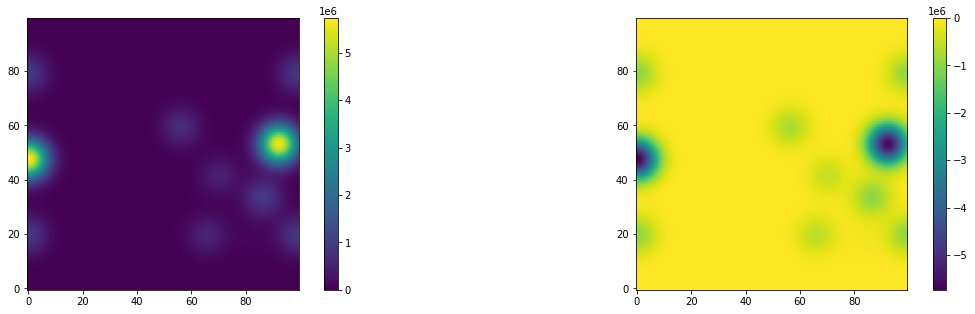

[-6.          5.86309719] [[-75735.14205484]]
[-6.          5.86309719]
single-processing, minimize, x_start = [-6.460029924919804, 6.33164779611342]
Minimizing finished, min point = [-6.          5.92690116]
New State: [[-6.          5.92690116]], [[-76085.1536538]]
iteration = 28
current position: [[-6.          5.92690116]] current best seen objective value: [[-75735.14205484]]


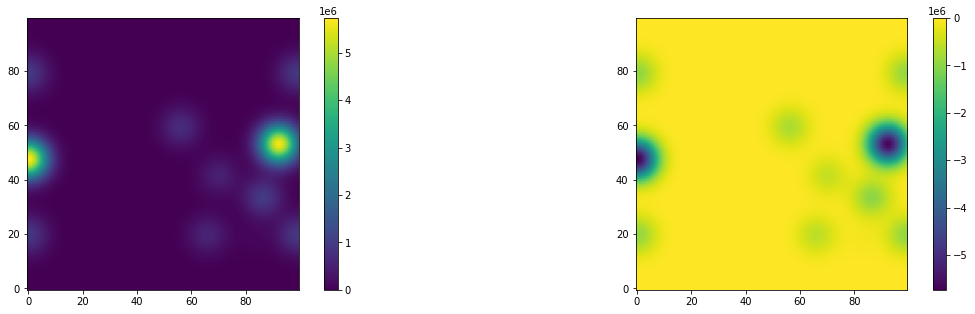

[-6.          5.86309719] [[-75735.14205484]]
[-6.          5.86309719]
single-processing, minimize, x_start = [-5.8823689072343965, 6.22012540821565]
Minimizing finished, min point = [-6.         5.9355838]
New State: [[-6.         5.9355838]], [[-76638.40654534]]
iteration = 29
current position: [[-6.         5.9355838]] current best seen objective value: [[-75735.14205484]]


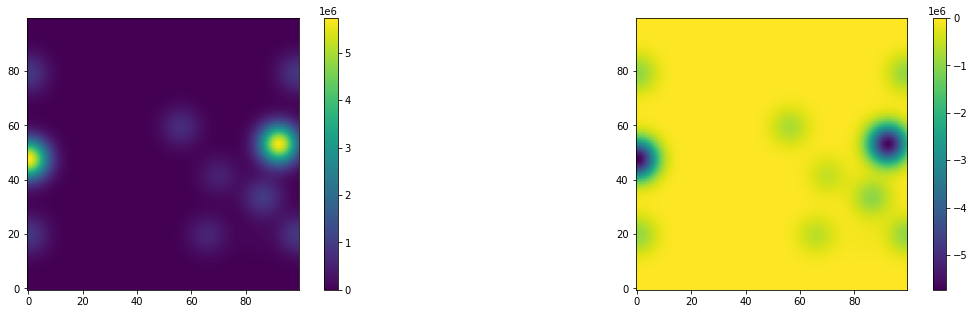

[-6.          5.86309719] [[-75735.14205484]]
[-6.          5.86309719]
single-processing, minimize, x_start = [-6.1301210330015365, 5.593574715519641]
Minimizing finished, min point = [-6.          5.92413242]
New State: [[-6.          5.92413242]], [[-76058.78904751]]
iteration = 30
current position: [[-6.          5.92413242]] current best seen objective value: [[-75735.14205484]]


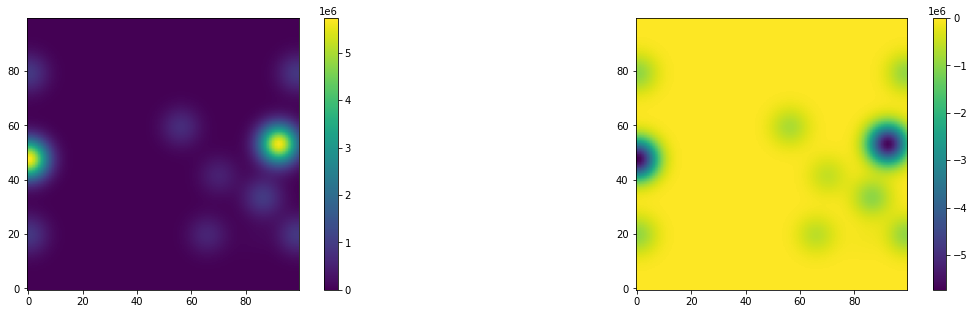

[-6.          5.86309719] [[-75735.14205484]]
[-6.          5.86309719]
single-processing, minimize, x_start = [-5.725923839328188, 6.096000635322259]
Minimizing finished, min point = [-6.          5.92432829]
New State: [[-6.          5.92432829]], [[-76092.27132216]]
iteration = 31
current position: [[-6.          5.92432829]] current best seen objective value: [[-75735.14205484]]


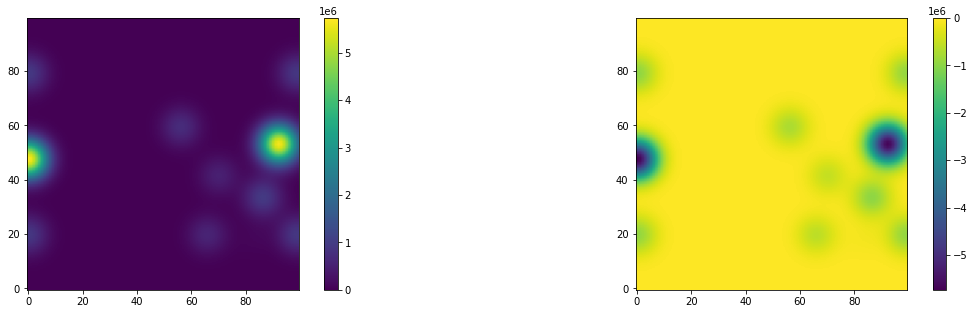

[-6.          5.86309719] [[-75735.14205484]]
[-6.          5.86309719]
single-processing, minimize, x_start = [-5.924174132838929, 5.688107247326077]
Minimizing finished, min point = [-6.          5.92430019]
New State: [[-6.          5.92430019]], [[-76092.29957508]]
iteration = 32
current position: [[-6.          5.92430019]] current best seen objective value: [[-75735.14205484]]


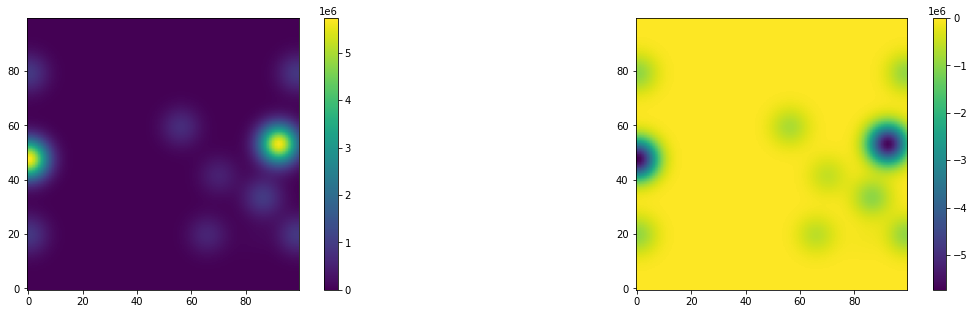

[-6.          5.86309719] [[-75735.14205484]]
[-6.          5.86309719]
single-processing, minimize, x_start = [-5.779730157905304, 6.298387539574752]
Minimizing finished, min point = [-6.          5.92449605]
New State: [[-6.          5.92449605]], [[-76092.32670675]]
iteration = 33
current position: [[-6.          5.92449605]] current best seen objective value: [[-75735.14205484]]


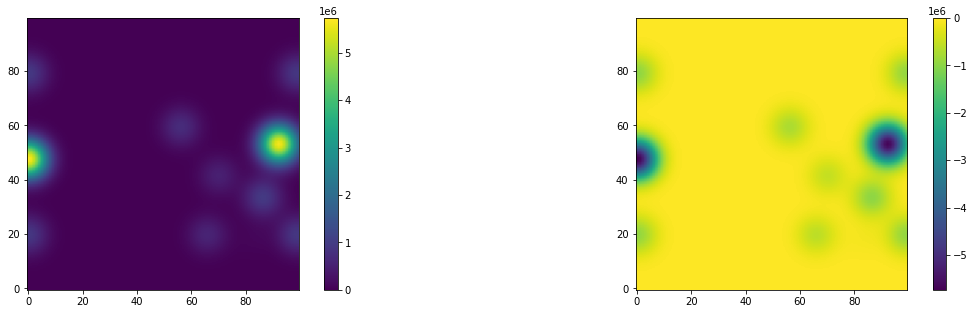

[-6.          5.86309719] [[-75735.14205484]]
[-6.          5.86309719]
single-processing, minimize, x_start = [-6.318315424813354, 6.240458983687912]
Minimizing finished, min point = [-6.          5.92451179]
New State: [[-6.          5.92451179]], [[-76092.7504742]]
iteration = 34
current position: [[-6.          5.92451179]] current best seen objective value: [[-75735.14205484]]


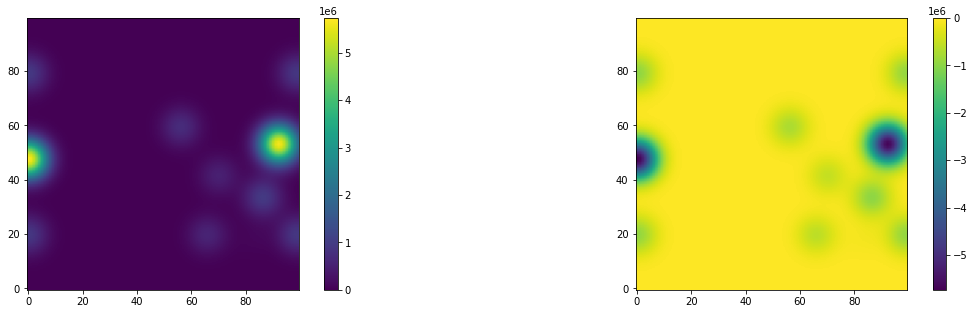

[-6.          5.86309719] [[-75735.14205484]]
[-6.          5.86309719]
single-processing, minimize, x_start = [-5.898344208794921, 6.1343709723772415]
Minimizing finished, min point = [-6.          5.92443445]
New State: [[-6.          5.92443445]], [[-76089.86752557]]
(array([-6.        ,  5.86309719]), array([[-75735.14205484]]))


In [100]:
# Test over single starting point
Niter = 35
for i in range(Niter):
    
    print ('iteration =', i)
    print ('current position:', mi.x, 'current best seen objective value:', Obj_state_s[-1])

    fig = plt.figure(figsize=(20,5))
    x = np.linspace(-10,10,100)
    y = np.linspace(-10,10,100)
    UCB = np.zeros((100,100))
    yval = UCB*0
    yerr = UCB*0
    for i in range(len(x)):
        for j in range(len(y)):
            UCB[i,j] = negUCB([x[i],y[j]],opt.model, 2, 0, 2, None)
            yval[i,j] = opt.model.predict(np.array([x[i],y[j]],ndmin=2))[0][0]
#             yerr[i,j] = opt.model.predict(np.array([x[i],y[j]],ndmin=2))[1][0]  # yerr matrix is not very helpful
            
    plt.subplot(121)
    plt.imshow(UCB,origin='lower')
    plt.colorbar()
#     plt.scatter((mi.x[0][0]+5)/0.01,(mi.x[0][1]+5)/0.01)
    
    plt.subplot(122)
    plt.imshow(yval,origin='lower')
    plt.colorbar()
#     plt.scatter((mi.x[0][0]+5)/0.01,(mi.x[0][1]+5)/0.01)
    
    plt.show()
    opt.OptIter()
    Obj_state_s.append(opt.best_seen()[1])
#     Obj_state_s.append(opt.OptIter()[1])
print(opt.best_seen())

(-0.5, 200.5, 200.5, -0.5)

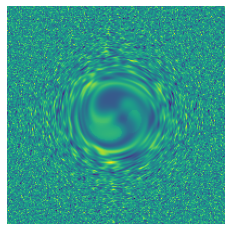

In [102]:
temp = np.load('/home/cz489/STEMalign_BO/ronchigram.npy')
plt.imshow(temp)
plt.axis('off')

/nfs/user/cz489/venv/lib64/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/nfs/user/cz489/venv/lib64/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


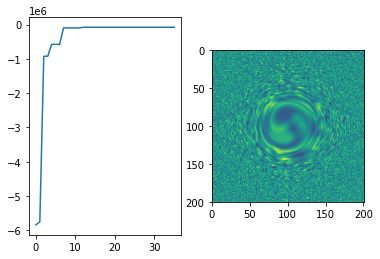

In [101]:
# print(opt.best_seen())
# print(np.asarray(Obj_state_s))
plt.subplot(121)
plt.plot(np.asarray(Obj_state_s))
plt.subplot(122)
temp = np.load('/home/cz489/STEMalign_BO/ronchigram.npy')
plt.imshow(temp)
np.save('Start_point_5.9_4.95_mag3e5_noise10_asymmetric.npy', np.asarray(Obj_state_s))

In [8]:
np.log(-Obj_list[i,2::])

array([13.63265145, 13.63265145, 13.63265145, 13.63265145, 13.63265145,
       13.63265145, 13.63265145, 13.63265145, 13.63265145, 13.63265145,
       13.63265145, 13.63265145, 13.22194002, 11.44825484, 11.44825484,
       11.44825484, 11.44825484, 11.44825484, 11.44825484, 11.44825484,
       11.44825484, 11.44825484, 11.44825484, 11.44825484, 11.44825484,
       11.44825484, 11.44825484, 11.44825484, 11.44825484, 11.44825484,
       11.44825484, 11.44825484, 11.44825484, 11.44825484, 11.44825484,
       11.44825484])

Text(0, 0.5, 'Emittance^2')

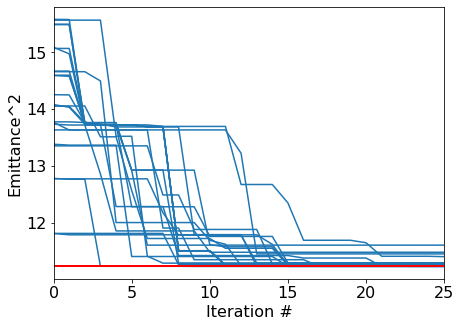

In [10]:
fig = plt.figure(figsize = (7,5))
Obj_list = np.load('DiffStartPointTest_asymmetric_extended.npy')
for i in range(Obj_list.shape[0]):
    plt.plot(np.log(-Obj_list[i,2::]), ls = '-',c='C0')
plt.xlim([0,25])
grid_search = np.load('2Dscan_-10-10_H1_H2.npy')
plt.axhline(y=np.log(-np.amax(grid_search)), c='red', linewidth = 2)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Iteration #', fontsize = 16)
plt.ylabel('Emittance^2', fontsize = 16)

In [9]:
# Test over multiple different starting point
Niter = 15
Ntest_point = 5
H1_list = np.linspace(-5.9,5.9, num = Ntest_point)
H2_list = np.linspace(-9.9,9.9,num = Ntest_point)
Obj_list = np.zeros((Ntest_point * Ntest_point, Niter + 3))
for i1 in range(Ntest_point):
    for i2 in range(Ntest_point):
        count = i1 * Ntest_point + i2
        start_point = [[H1_list[i1],H2_list[i2]]]

        # For each starting point, create a new mi with the new start_point par, then a new opt to connect to the new mi
        mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) 
        gp_ls = np.array(np.ones(ndim))
        gp_amp = 3e5 # default = 1
        gp_noise = 10  # default = 0.001

        gp_precisionmat =  np.array(np.diag(1/(gp_ls**2)))
        hyps = [gp_precisionmat, np.log(gp_amp), np.log(gp_noise**2)] #format the hyperparams for the OGP

        gp = OGP(ndim, hyps,prmean=0)
        
        opt = BayesOpt(gp, mi, acq_func="UCB", start_dev_vals = mi.x, dev_ids = dev_ids)
        opt.ucb_params = np.array([2, None])
        Obj_list[count,0] = H1_list[i1]  # starting points
        Obj_list[count,1] = H2_list[i2]
        Obj_list[count,2] = mi.getState()[1][0]  # initial state

        for i in range(Niter):
            opt.OptIter()
            Obj_list[count,i+3] = opt.best_seen()[1]  # save the best objective in each iteration
#             Obj_state_s.append(opt.best_seen()[1])
        print(str(H1_list[i1]) + ', ' + str(H2_list[i2]) + ' Finished.')
        np.save('DiffStarPointTest_asymmetric.npy',Obj_list)

target_func =  <machine_interfaces.machine_interface_GPT.machine_interface object at 0x7f0ee8542d30>
********* BO - self.mi = self.target_func wORKED!
Supposed to be grabbing initial machine state...
x_init [[-5.9 -9.9]]
y_init [[-959958.82380779]]
Using prior mean function of  0
Using prior mean parameters of  None
[-5.9 -9.9] [[-959958.82380779]]
[-5.9 -9.9]
single-processing, minimize, x_start = [array([-5.88277214]), array([-9.90119216])]
Minimizing finished, min point = [-5.88277214 -9.90119216]
New State: [[-5.88277214 -9.90119216]], [[-962354.75984406]]
[-5.9 -9.9] [[-959958.82380779]]
[-5.9 -9.9]
single-processing, minimize, x_start = [array([-5.88277214]), array([-9.90119216])]
Minimizing finished, min point = [ 6.         -9.90119216]
New State: [[ 6.         -9.90119216]], [[-948795.2692584]]
[ 6.         -9.90119216] [[-948795.2692584]]
[ 6.         -9.90119216]
single-processing, minimize, x_start = [array([6.01722786]), array([-9.90238432])]
Minimizing finished, min point

New State: [[ 6.         -5.79280527]], [[-78019.00193133]]
[ 6.         -5.82130735] [[-76785.59879074]]
[ 6.         -5.82130735]
single-processing, minimize, x_start = [array([6.01722786]), array([-5.82249951])]
Minimizing finished, min point = [ 6.        -5.7926061]
New State: [[ 6.        -5.7926061]], [[-78030.20213385]]
-5.9, -4.95 Finished.
target_func =  <machine_interfaces.machine_interface_GPT.machine_interface object at 0x7f0ee5ec2e48>
********* BO - self.mi = self.target_func wORKED!
Supposed to be grabbing initial machine state...
x_init [[-5.9  0. ]]
y_init [[-1549620.78792957]]
Using prior mean function of  0
Using prior mean parameters of  None
[-5.9  0. ] [[-1549620.78792957]]
[-5.9  0. ]
single-processing, minimize, x_start = [array([-5.88277214]), array([-0.00119216])]
Minimizing finished, min point = [-5.88277214e+00 -1.19216008e-03]
New State: [[-5.88277214e+00 -1.19216008e-03]], [[-1543083.06402783]]
[-5.88277214e+00 -1.19216008e-03] [[-1543083.06402783]]
[-5.88

New State: [[-6.          4.87139115]], [[-157994.48782865]]
[-5.88277214  4.94880784] [[-131202.83910959]]
[-5.88277214  4.94880784]
single-processing, minimize, x_start = [array([-5.86554429]), array([4.94761568])]
Minimizing finished, min point = [-4.77625147  5.52712657]
New State: [[-4.77625147  5.52712657]], [[-110959.77749902]]
[-4.77625147  5.52712657] [[-110959.77749902]]
[-4.77625147  5.52712657]
single-processing, minimize, x_start = [array([-4.75902361]), array([5.52593441])]
Minimizing finished, min point = [-5.33597884  5.2786756 ]
New State: [[-5.33597884  5.2786756 ]], [[-75789.57395784]]
-5.9, 4.950000000000001 Finished.
target_func =  <machine_interfaces.machine_interface_GPT.machine_interface object at 0x7f0ee80af550>
********* BO - self.mi = self.target_func wORKED!
Supposed to be grabbing initial machine state...
x_init [[-5.9  9.9]]
y_init [[-921690.44120017]]
Using prior mean function of  0
Using prior mean parameters of  None
[-5.9  9.9] [[-921690.44120017]]
[-5

New State: [[ 6.         -5.79480629]], [[-77927.09587013]]
[ 6.         -5.82130735] [[-76785.59879074]]
[ 6.         -5.82130735]
single-processing, minimize, x_start = [array([6.01722786]), array([-5.82249951])]
Minimizing finished, min point = [ 6.         -5.79327814]
New State: [[ 6.         -5.79327814]], [[-78050.62728272]]
[ 6.         -5.82130735] [[-76785.59879074]]
[ 6.         -5.82130735]
single-processing, minimize, x_start = [array([6.01722786]), array([-5.82249951])]
Minimizing finished, min point = [ 6.         -5.79280527]
New State: [[ 6.         -5.79280527]], [[-78019.00193133]]
[ 6.         -5.82130735] [[-76785.59879074]]
[ 6.         -5.82130735]
single-processing, minimize, x_start = [array([6.01722786]), array([-5.82249951])]
Minimizing finished, min point = [ 6.        -5.7926061]
New State: [[ 6.        -5.7926061]], [[-78030.20213385]]
-2.95, -9.9 Finished.
target_func =  <machine_interfaces.machine_interface_GPT.machine_interface object at 0x7f0f2c9c2160>

New State: [[-3.62299745 -5.19519048]], [[-4780256.45736889]]
[ 0.78751993 -1.2515481 ] [[-89518.05404469]]
[ 0.78751993 -1.2515481 ]
single-processing, minimize, x_start = [array([0.80474779]), array([-1.25274026])]
Minimizing finished, min point = [-0.95906978 -2.57684792]
New State: [[-0.95906978 -2.57684792]], [[-783610.10622313]]
[ 0.78751993 -1.2515481 ] [[-89518.05404469]]
[ 0.78751993 -1.2515481 ]
single-processing, minimize, x_start = [array([0.80474779]), array([-1.25274026])]
Minimizing finished, min point = [ 6. 10.]
New State: [[ 6. 10.]], [[-909560.60057203]]
[ 0.78751993 -1.2515481 ] [[-89518.05404469]]
[ 0.78751993 -1.2515481 ]
single-processing, minimize, x_start = [array([0.80474779]), array([-1.25274026])]
Minimizing finished, min point = [ 1.74247706 -1.08766311]
New State: [[ 1.74247706 -1.08766311]], [[-102412.45501308]]
[ 0.78751993 -1.2515481 ] [[-89518.05404469]]
[ 0.78751993 -1.2515481 ]
single-processing, minimize, x_start = [array([0.80474779]), array([-1.25

New State: [[ 6.         -5.18115131]], [[-119088.92129906]]
[ 6.         -5.18115131] [[-119088.92129906]]
[ 6.         -5.18115131]
single-processing, minimize, x_start = [array([6.01722786]), array([-5.18234347])]
Minimizing finished, min point = [ 6.         -5.24575104]
New State: [[ 6.         -5.24575104]], [[-111113.69183672]]
[ 6.         -5.24575104] [[-111113.69183672]]
[ 6.         -5.24575104]
single-processing, minimize, x_start = [array([6.01722786]), array([-5.2469432])]
Minimizing finished, min point = [ 5.99998893 -5.87408128]
New State: [[ 5.99998893 -5.87408128]], [[-76210.15249007]]
[ 5.99998893 -5.87408128] [[-76210.15249007]]
[ 5.99998893 -5.87408128]
single-processing, minimize, x_start = [array([6.01721679]), array([-5.87527344])]
Minimizing finished, min point = [ 6.         -5.91096382]
New State: [[ 6.         -5.91096382]], [[-76377.42675071]]
[ 5.99998893 -5.87408128] [[-76210.15249007]]
[ 5.99998893 -5.87408128]
single-processing, minimize, x_start = [arr

New State: [[ 6.        -3.8082181]], [[-407017.12179314]]
[ 6.         -5.39253582] [[-99095.24677299]]
[ 6.         -5.39253582]
single-processing, minimize, x_start = [array([6.01722786]), array([-5.39372798])]
Minimizing finished, min point = [ 6.         -5.83450093]
New State: [[ 6.         -5.83450093]], [[-77071.77505842]]
[ 6.         -5.83450093] [[-77071.77505842]]
[ 6.         -5.83450093]
single-processing, minimize, x_start = [array([6.01722786]), array([-5.83569309])]
Minimizing finished, min point = [ 5.99984946 -5.79746349]
New State: [[ 5.99984946 -5.79746349]], [[-77696.74916951]]
[ 6.         -5.83450093] [[-77071.77505842]]
[ 6.         -5.83450093]
single-processing, minimize, x_start = [array([6.01722786]), array([-5.83569309])]
Minimizing finished, min point = [ 6.         -5.79747936]
New State: [[ 6.         -5.79747936]], [[-77696.34065064]]
[ 6.         -5.83450093] [[-77071.77505842]]
[ 6.         -5.83450093]
single-processing, minimize, x_start = [array([

New State: [[4.30739053 1.03100974]], [[-1323763.48355546]]
[ 5.98637624 -6.84914117] [[-122955.30523299]]
[ 5.98637624 -6.84914117]
single-processing, minimize, x_start = [array([6.00360409]), array([-6.85033333])]
Minimizing finished, min point = [-0.04464956  0.71704512]
New State: [[-0.04464956  0.71704512]], [[-103488.75385364]]
[-0.04464956  0.71704512] [[-103488.75385364]]
[-0.04464956  0.71704512]
single-processing, minimize, x_start = [array([-0.0274217]), array([0.71585296])]
Minimizing finished, min point = [ 2.77769962 -6.2919477 ]
New State: [[ 2.77769962 -6.2919477 ]], [[-786553.29713684]]
[-0.04464956  0.71704512] [[-103488.75385364]]
[-0.04464956  0.71704512]
single-processing, minimize, x_start = [array([-0.0274217]), array([0.71585296])]
Minimizing finished, min point = [ 3.31162918 -2.43547873]
New State: [[ 3.31162918 -2.43547873]], [[-125273.26128446]]
[-0.04464956  0.71704512] [[-103488.75385364]]
[-0.04464956  0.71704512]
single-processing, minimize, x_start = [a

New State: [[  6. -10.]], [[-951008.28159938]]
[  6. -10.] [[-951008.28159938]]
[  6. -10.]
single-processing, minimize, x_start = [array([6.01722786]), array([-10.00119216])]
Minimizing finished, min point = [  6. -10.]
New State: [[  6. -10.]], [[-951008.28159938]]
[  6. -10.] [[-951008.28159938]]
[  6. -10.]
single-processing, minimize, x_start = [array([6.01722786]), array([-10.00119216])]
Minimizing finished, min point = [  6. -10.]
New State: [[  6. -10.]], [[-951008.28159938]]
[  6. -10.] [[-951008.28159938]]
[  6. -10.]
single-processing, minimize, x_start = [array([6.01722786]), array([-10.00119216])]
Minimizing finished, min point = [  6. -10.]
New State: [[  6. -10.]], [[-951008.28159938]]
[  6. -10.] [[-951008.28159938]]
[  6. -10.]
single-processing, minimize, x_start = [array([6.01722786]), array([-10.00119216])]
Minimizing finished, min point = [  6. -10.]
New State: [[  6. -10.]], [[-951008.28159938]]
[  6. -10.] [[-951008.28159938]]
[  6. -10.]
single-processing, minim

New State: [[ 4.87309063 -7.1448276 ]], [[-432097.3185084]]
[ 4.03578728 -5.06611987] [[-144197.51420057]]
[ 4.03578728 -5.06611987]
single-processing, minimize, x_start = [array([4.05301514]), array([-5.06731203])]
Minimizing finished, min point = [-6. 10.]
New State: [[-6. 10.]], [[-921690.44120017]]
[ 4.03578728 -5.06611987] [[-144197.51420057]]
[ 4.03578728 -5.06611987]
single-processing, minimize, x_start = [array([4.05301514]), array([-5.06731203])]
Minimizing finished, min point = [ 1.78869088 -3.22187417]
New State: [[ 1.78869088 -3.22187417]], [[-210085.20405146]]
[ 4.03578728 -5.06611987] [[-144197.51420057]]
[ 4.03578728 -5.06611987]
single-processing, minimize, x_start = [array([4.05301514]), array([-5.06731203])]
Minimizing finished, min point = [ 6.        -2.3195406]
New State: [[ 6.        -2.3195406]], [[-802943.9334776]]
[ 4.03578728 -5.06611987] [[-144197.51420057]]
[ 4.03578728 -5.06611987]
single-processing, minimize, x_start = [array([4.05301514]), array([-5.06731

New State: [[ 6. 10.]], [[-909560.60057203]]
[ 6. 10.] [[-909560.60057203]]
[ 6. 10.]
single-processing, minimize, x_start = [array([6.01722786]), array([9.99880784])]
Minimizing finished, min point = [ 6. 10.]
New State: [[ 6. 10.]], [[-909560.60057203]]
[ 6. 10.] [[-909560.60057203]]
[ 6. 10.]
single-processing, minimize, x_start = [array([6.01722786]), array([9.99880784])]
Minimizing finished, min point = [ 6. 10.]
New State: [[ 6. 10.]], [[-909560.60057203]]
[ 6. 10.] [[-909560.60057203]]
[ 6. 10.]
single-processing, minimize, x_start = [array([6.01722786]), array([9.99880784])]
Minimizing finished, min point = [ 6. 10.]
New State: [[ 6. 10.]], [[-909560.60057203]]
2.950000000000001, 9.9 Finished.
target_func =  <machine_interfaces.machine_interface_GPT.machine_interface object at 0x7f0ee5f697b8>
********* BO - self.mi = self.target_func wORKED!
Supposed to be grabbing initial machine state...
x_init [[ 5.9 -9.9]]
y_init [[-951008.28159938]]
Using prior mean function of  0
Using pr

New State: [[ 5.92250148 -5.69942874]], [[-78819.75774369]]
[ 5.9172263  -5.72010378] [[-77425.10978553]]
[ 5.9172263  -5.72010378]
single-processing, minimize, x_start = [array([5.93445415]), array([-5.72129594])]
Minimizing finished, min point = [ 5.91770773 -5.69875201]
New State: [[ 5.91770773 -5.69875201]], [[-78395.41630372]]
[ 5.9172263  -5.72010378] [[-77425.10978553]]
[ 5.9172263  -5.72010378]
single-processing, minimize, x_start = [array([5.93445415]), array([-5.72129594])]
Minimizing finished, min point = [ 5.87778596 -5.69844857]
New State: [[ 5.87778596 -5.69844857]], [[-76880.13441647]]
5.9, -4.95 Finished.
target_func =  <machine_interfaces.machine_interface_GPT.machine_interface object at 0x7f0eeb698a90>
********* BO - self.mi = self.target_func wORKED!
Supposed to be grabbing initial machine state...
x_init [[5.9 0. ]]
y_init [[-1301339.51636746]]
Using prior mean function of  0
Using prior mean parameters of  None
[5.9 0. ] [[-1301339.51636746]]
[5.9 0. ]
single-proce

New State: [[5.91722786 4.94880784]], [[-5330419.36169608]]
[5.9  4.95] [[-5321683.93689869]]
[5.9  4.95]
single-processing, minimize, x_start = [array([5.91722786]), array([4.94880784])]
Minimizing finished, min point = [5.91722786 4.94880784]
New State: [[5.91722786 4.94880784]], [[-5330419.36169608]]
[5.9  4.95] [[-5321683.93689869]]
[5.9  4.95]
single-processing, minimize, x_start = [array([5.91722786]), array([4.94880784])]
Minimizing finished, min point = [5.91722786 4.94880784]
New State: [[5.91722786 4.94880784]], [[-5330419.36169608]]
5.9, 4.950000000000001 Finished.
target_func =  <machine_interfaces.machine_interface_GPT.machine_interface object at 0x7f0ee81d6710>
********* BO - self.mi = self.target_func wORKED!
Supposed to be grabbing initial machine state...
x_init [[5.9 9.9]]
y_init [[-832885.49506187]]
Using prior mean function of  0
Using prior mean parameters of  None
[5.9 9.9] [[-832885.49506187]]
[5.9 9.9]
single-processing, minimize, x_start = [array([5.91722786]),

In [25]:
grid_search = np.load('2Dscan_-10-10_H1_H2.npy')
np.amax(grid_search)

-76330.25573555657

Text(0, 0.5, 'Emittance^2')

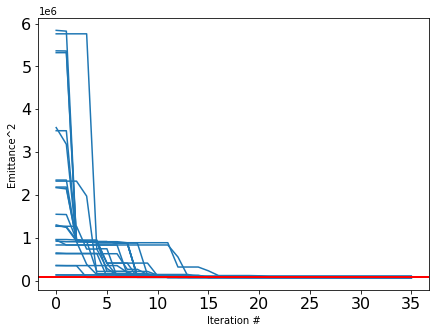

In [81]:
fig = plt.figure(figsize = (7,5))
for i in range(Obj_list.shape[0]):
    plt.plot(-Obj_list[i,2::], '-',c='C0')
grid_search = np.load('2Dscan_-10-10_H1_H2.npy')
plt.axhline(y=-np.amax(grid_search), c='red', linewidth = 2)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Iteration #', fontsize = 16)
plt.ylabel('Emittance^2')

In [28]:
Obj_list = np.load('DiffStarPointTest_asymmetric.npy')
idx = np.where(Obj_list[:,-1]<-100000)
print(Obj_list[idx,0:2])
print(idx)

[[[-5.9  -9.9 ]
  [ 0.   -9.9 ]
  [ 2.95 -9.9 ]
  [ 2.95  4.95]
  [ 2.95  9.9 ]
  [ 5.9  -9.9 ]
  [ 5.9   0.  ]
  [ 5.9   4.95]]]
(array([ 0, 10, 15, 18, 19, 20, 22, 23]),)


## Test behavior of the negative UCB function and scipy.optimize.minimize

In [8]:
print(opt.OptIter())
# print('negUCB = ' + str(negUCB([4.0,4.0], opt.model, 1, 0)))
# print(opt.model.predict(np.array([4.9,4.9],ndmin=2)))

[7.9 7.1] [[-924053.03617951]]
[7.9 7.1]
single-processing, minimize, x_start = [0, 0]
Minimizing finished, min point = [0. 0.]
New State: [[0. 0.]], [[-76330.25573556]]
(array([[0., 0.]]), array([[-76330.25573556]]))


In [9]:
opt.acq_func[0]

'UCB'

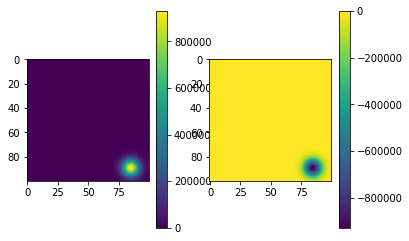

In [10]:
x = np.linspace(-10,10,100)
y = np.linspace(-10,10,100)
UCB = np.zeros((100,100))
yval = UCB*0
yerr = UCB*0
for i in range(len(x)):
    for j in range(len(y)):
        UCB[i,j] = negUCB([x[i],y[j]],opt.model, 1, 0)
        yval[i,j] = opt.model.predict(np.array([x[i],y[j]],ndmin=2))[0][0]
        yerr[i,j] = opt.model.predict(np.array([x[i],y[j]],ndmin=2))[1][0]
plt.subplot(121)
plt.imshow(UCB)
plt.colorbar()
plt.subplot(122)
plt.imshow(yval)
plt.colorbar()

In [21]:
bnds = [(-10, 10),(-10,10)]
x0 = [7.901, 7.1]
x0 = [x + 0.001 for x in x0]
ndim = 2
nsteps = 1
nu = 2
delta = None
res = scipy.optimize.minimize(negUCB, x0, args=(opt.model, ndim, nsteps, nu, delta), 
                              method='L-BFGS-B',tol=1e-4,bounds=bnds,options={'maxiter':1000})     
print(res.x)

[10. 10.]


In [19]:
len(x0)

2

In [30]:
negUCB([7.899,7.099],opt.model, 1, 0, 2, None)

931715.8967290218

## Scan Test
Test a series of different values for the hexapoles to determine the noise and magnitute that should be used for the GP.
<br>The calculated emittance vs hexpole current can also be used as a reference for the real objective function during the GP test.

In [9]:
# 1D scan along hex1 = hex2
ndim = 1 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation
dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
hex_list = np.linspace(-10,10,num=100)
emit_list = []

for i in range(len(hex_list)):
    start_point = [[0,hex_list[i]]] 
    mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
    mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) #an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1
    emit_list.append(mi.getState()[1][0])
#     print(hex_list[i], emit_list[-1])

(array([-1000000.,        0.,  1000000.,  2000000.,  3000000.,  4000000.,
         5000000.,  6000000.,  7000000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

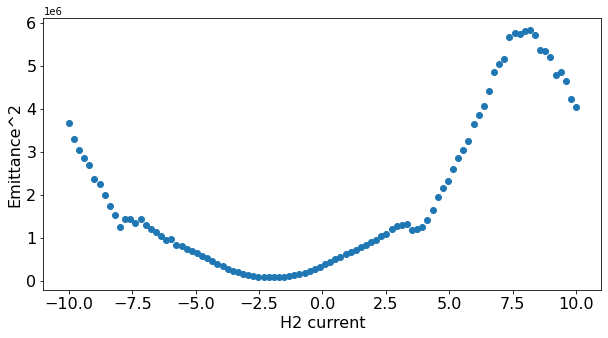

In [11]:
emit_list = np.load('emit_list_ref_H2=-10_10_H1=2_100steps.npy')
hex_list = np.load('hex_list_ref_H2=-10_10_H1=2_100steps.npy')

fig = plt.figure(figsize = [10,5])
plt.scatter(hex_list, -np.asarray(emit_list))
plt.ylabel('Emittance^2',fontsize = 16)
plt.xlabel('H2 current',fontsize  = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.savefig('hex_scan_h1=-100_100_h2=8.png')

# np.save('emit_list_ref_H2=-10_10_H1=0_100steps.npy',np.asarray(emit_list))
# np.save('hex_list_ref_H2=-10_10_H1=0_100steps.npy',hex_list)

10.0 10.0 -1274515.0433124676


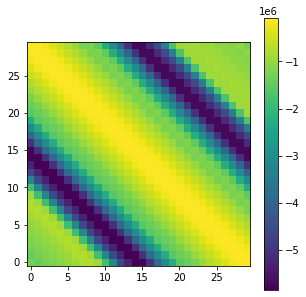

In [5]:
# 2D parameter scan for all (hex1, hex2) pairs
ndim = 2 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation
dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
hex_list = np.linspace(-10,10,num=30)
emit_matrix = np.zeros([30, 30])

for i in range(len(hex_list)):
    for j in range(len(hex_list)):
        imgname = '/home/cz489/STEMalign_BO/SimulationResults/ronchigram_'+ str(i)+'_'+str(j)+'.npy'
        txtname = '/home/cz489/STEMalign_BO/SimulationResults/outscope_'+ str(i)+'_'+str(j)+'.txt'
        if os.path.exists(txtname):
            emit_matrix[i,j] = calcEmittance(txtname)
        else:
            start_point = [[hex_list[i],hex_list[j]]]  # use H1 = H2 = 25 as default start, following Cameron's setup
            mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
            mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) #an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1
            emit_matrix[i,j] = mi.getState()[1][0]
            
            
#             os.rename("/home/cz489/STEMalign_BO/outscope.txt", txtname)
#             os.rename("/home/cz489/STEMalign_BO/ronchigram.npy", imgname)
        
        clear_output(wait=True)
        print(hex_list[i], hex_list[j], emit_matrix[i,j])
        fig = plt.figure(figsize = [5,5])
        plt.imshow(emit_matrix, origin='lower')
        plt.colorbar()
        plt.show()
        fig.savefig('2Dscan_-10-10_H1_H2.png')
        np.save('2Dscan_-10-10_H1_H2.npy',emit_matrix)

            

Text(0, 0.5, 'Emittance^2')

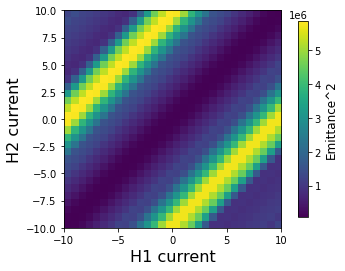

In [27]:
emit_matrix = np.load('2Dscan_-10-10_H1_H2.npy')
fig, ax = plt.subplots(1,1)
img = ax.imshow(-emit_matrix,extent=[-10,10,-10,10])
ax.set_xlabel('H1 current',fontsize = 16)
ax.set_ylabel('H2 current', fontsize = 16)
cbar = fig.colorbar(img, ax=ax, shrink=0.9)
cbar.ax.set_ylabel('Emittance^2',fontsize = 12)

## Aux Functions

## Previously used scripts